In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('./Hawaiian_airlines.xlsx', sheet_name='Sheet1')
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

In [ ]:
df.shape

(120, 23)

In [ ]:
df.describe()

,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_TIME,ARR_DELAY,DELAY,CANCELLED,DEP_DELAY
count,120,120.000000,120.000000,120.0,120.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,118.000000,120.0000,120.000000,120.000000
mean,2018-12-16 04:00:00,34.583333,32572.133333,32211.0,1596.500000,1580.705882,19.865546,15.899160,1545.176471,1496.983193,9.806723,1470.487395,2.703390,103.5780,0.008333,103.816667
min,2014-01-01 00:00:00,6.000000,32134.000000,32211.0,400.000000,11.000000,-16.000000,8.000000,2.000000,10.000000,5.000000,3.000000,-44.000000,55.6800,0.000000,56.000000
25%,2016-06-23 12:00:00,8.000000,32134.000000,32211.0,1525.000000,1519.500000,-2.500000,13.500000,1033.000000,677.000000,8.000000,681.500000,-23.500000,84.6700,0.000000,85.000000
50%,2018-12-16 12:00:00,18.000000,32134.000000,32211.0,1615.000000,1611.000000,4.000000,15.000000,1620.000000,1543.000000,9.000000,1546.000000,-7.000000,98.6500,0.000000,99.000000
75%,2021-06-08 12:00:00,32.000000,33830.000000,32211.0,2330.000000,2086.500000,22.000000,18.000000,1743.500000,2309.000000,11.000000,2314.500000,9.000000,120.0125,0.000000,120.500000
max,2023-12-01 00:00:00,1102.000000,33830.000000,32211.0,2340.000000,2357.000000,321.000000,26.000000,2359.000000,2358.000000,23.000000,2356.000000,318.000000,196.5400,1.000000,197.000000
std,NaN,139.794422,745.482743,0.0,550.039953,574.087018,50.227773,3.902183,606.921862,808.267314,3.202958,823.012211,44.963292,27.6657,0.091287,27.594295


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   FL_DATE                120 non-null    datetime64[ns]
 1   MKT_UNIQUE_CARRIER     120 non-null    object        
 2   OP_UNIQUE_CARRIER      120 non-null    object        
 3   TAIL_NUM               119 non-null    object        
 4   OP_CARRIER_FL_NUM      120 non-null    int64         
 5   ORIGIN_CITY_MARKET_ID  120 non-null    int64         
 6   ORIGIN_CITY_NAME       120 non-null    object        
 7   ORIGIN_STATE_ABR       120 non-null    object        
 8   DEST_CITY_MARKET_ID    120 non-null    int64         
 9   DEST_CITY_NAME         120 non-null    object        
 10  DEST_STATE_ABR         120 non-null    object        
 11  CRS_DEP_TIME           120 non-null    int64         
 12  DEP_TIME               119 non-null    float64       
 13  DEP  

# Stationarity Test

In [ ]:
monthly_delays = df.groupby(pd.Grouper(key='FL_DATE', freq='M'))['DEP_DELAY'].mean()

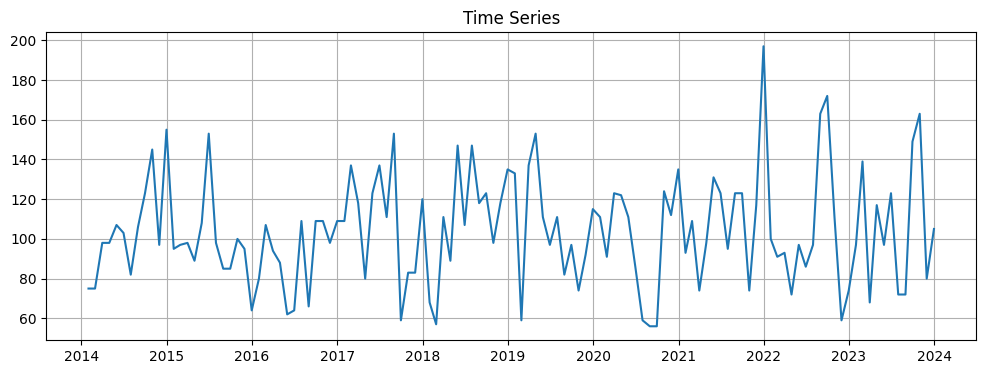

(120,)


In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(monthly_delays)
plt.title("Time Series")
plt.grid(True)
plt.show()
print(monthly_delays.shape)

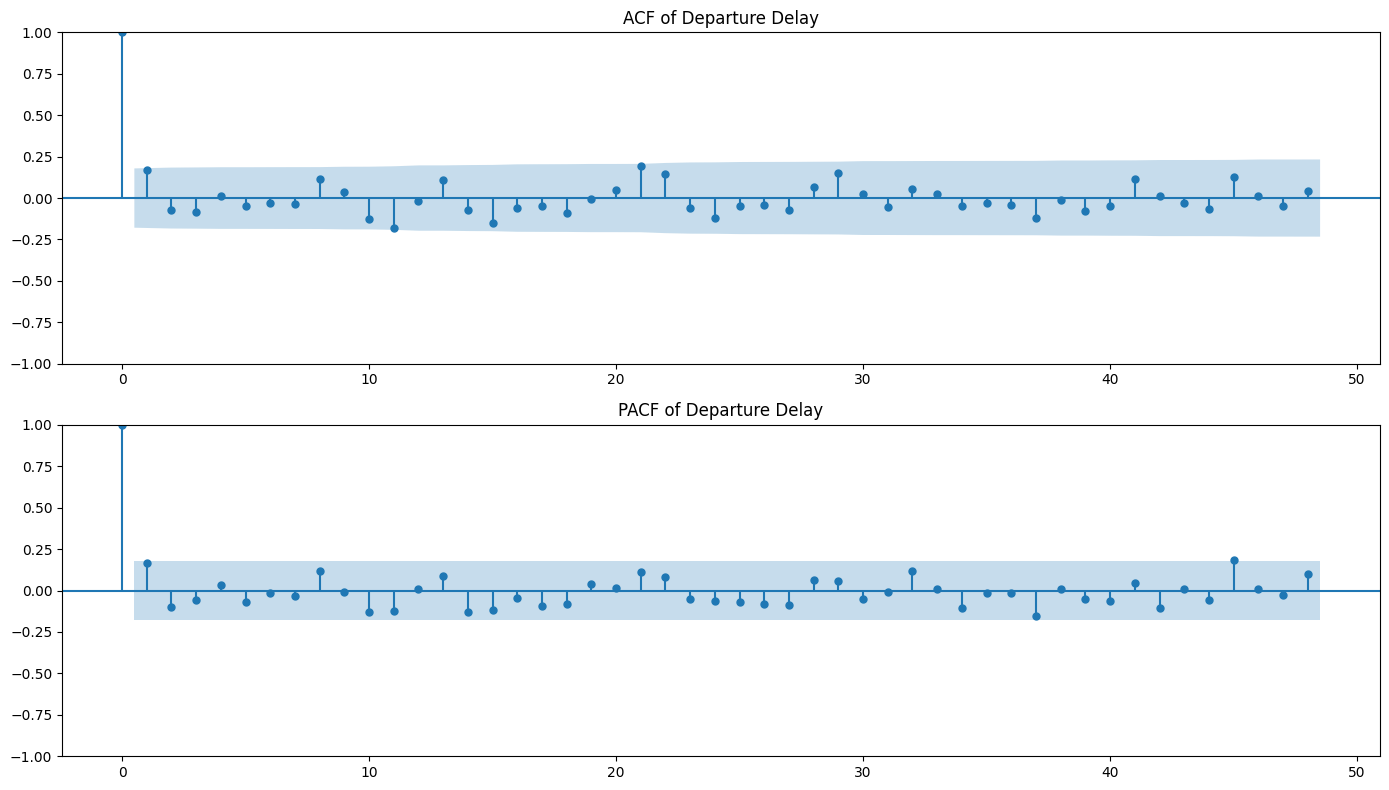

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(211)
plot_acf(monthly_delays, ax=plt.gca(), lags=48, alpha=0.05)
plt.title('ACF of Departure Delay')

plt.subplot(212)
plot_pacf(monthly_delays, ax=plt.gca(), lags=48, method='ywm', alpha=0.05)
plt.title('PACF of Departure Delay')

plt.tight_layout()
plt.show()

In [ ]:
print('Augmented Dickey-Fuller (ADF) Test')
adf = adfuller(monthly_delays)
print(f'ADF Test Statistic: {adf[0]:}')
print(f'p value: {adf[1]:}')
if adf[1] < 0.05:
    print("\n Reject the null hypothesis,the data is stationary")
else:
    print("\n Fail to reject the null,the data is not stationary")

Augmented Dickey-Fuller (ADF) Test
ADF Test Statistic: -9.17547965004152
p value: 2.326442218810547e-15

 Reject the null hypothesis,the data is stationary


In [ ]:
pnc1 = monthly_delays.dropna()
a = b = c = range(3)
res = []
for p in a:
    for d in b:
        for q in c:
                m = ARIMA(pnc1, order=(p, d, q))
                r = m.fit()
                res.append({'order': (p, d, q), 'AIC': r.aic, 'BIC': r.bic})
df = pd.DataFrame(res).sort_values('AIC').reset_index(drop=True)
print(df.head(6))

       order          AIC          BIC
0  (0, 1, 2)  1133.783627  1142.120998
1  (1, 1, 1)  1134.315420  1142.652791
2  (2, 1, 1)  1135.285213  1146.401707
3  (1, 1, 2)  1135.738403  1146.854897
4  (2, 0, 2)  1135.798142  1152.523093
5  (0, 1, 1)  1136.092553  1141.650800


In [ ]:
ts_data = monthly_delays.dropna()
model_arma = ARIMA(ts_data, order=(2, 0, 2))
results_arma = model_arma.fit()

In [ ]:
print(f"AIC : {results_arma.aic}")
print(f"BIC : {results_arma.bic}")

AIC : 1135.7981423634965
BIC : 1152.5230928201888


In [ ]:
resid = results_arma.filter_results.standardized_forecasts_error[0]
resid = pd.Series(resid).dropna()

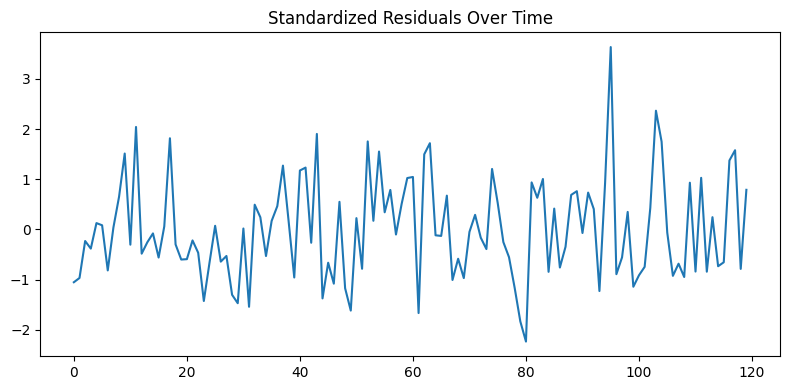

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(resid)
ax1.set_title('Standardized Residuals Over Time')
plt.tight_layout()
plt.show()

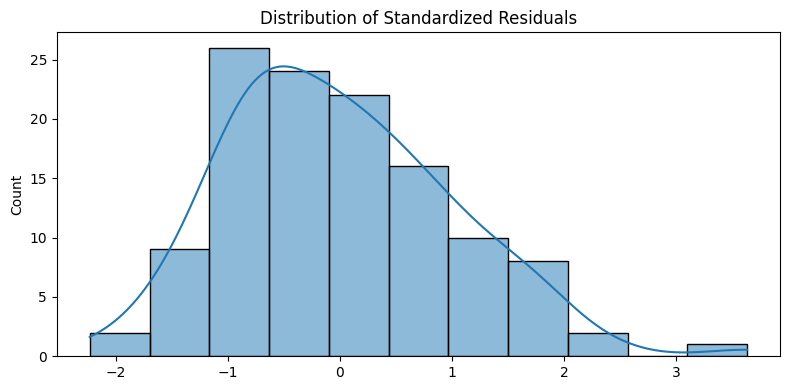

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8, 4))
sns.histplot(resid, kde=True, ax=ax2)
ax2.set_title('Distribution of Standardized Residuals')
plt.tight_layout()
plt.show()

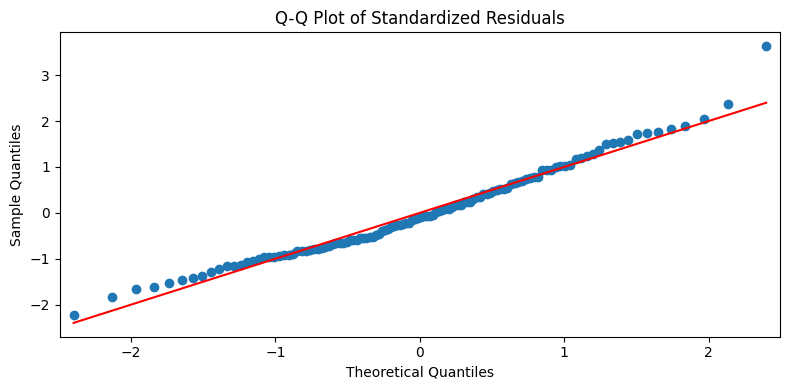

In [ ]:
fig3, ax3 = plt.subplots(figsize=(8, 4))
sm.qqplot(resid, line='s', ax=ax3)
ax3.set_title('Q-Q Plot of Standardized Residuals')
plt.tight_layout()
plt.show()

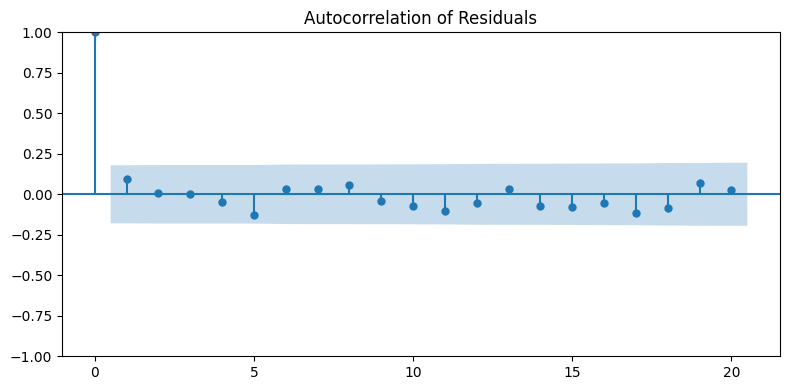

In [ ]:
fig4, ax4 = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax4)
ax4.set_title('Autocorrelation of Residuals')
plt.tight_layout()
plt.show()

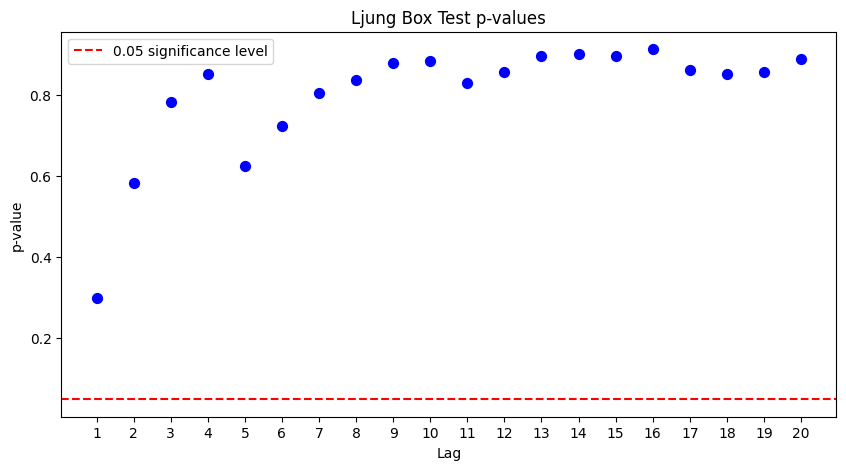

In [ ]:
lb_test = acorr_ljungbox(resid, lags=20, return_df=True)
lags = np.arange(1, 21)
plt.figure(figsize=(10, 5))
plt.scatter(lags, lb_test['lb_pvalue'].values, color='blue', s=50)
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('Ljung Box Test p-values')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.xticks(lags)
plt.legend()
plt.show()

In [ ]:
print(lb_test['lb_pvalue'])

1     0.300254
2     0.582530
3     0.781723
4     0.851261
5     0.623961
6     0.723484
7     0.805789
8     0.835601
9     0.878496
10    0.883556
11    0.829590
12    0.857358
13    0.895063
14    0.899719
15    0.894972
16    0.912457
17    0.862433
18    0.852568
19    0.857106
20    0.888285
Name: lb_pvalue, dtype: float64


In [ ]:
shap_stat, shap_p = shapiro(resid)
print(f"Shapiro-Wilk test: W = {shap_stat:}, p-value = {shap_p:}")

if shap_p > 0.05:
    print("Evidence suggests that the samples are normally distributed")
else:
    print("The samples are not normally distributed")

Shapiro-Wilk test: W = 0.9773518083821952, p-value = 0.04046057180093303
The samples are not normally distributed


In [ ]:
n_forecast = 6
forecast = results_arma.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
forecast_values = forecast_values.clip(lower=0)
conf_int = forecast.conf_int()
forecast_values = np.ceil(forecast_values)
conf_int.iloc[:, 0] = np.floor(conf_int.iloc[:, 0])
conf_int.iloc[:, 1] = np.ceil(conf_int.iloc[:, 1])

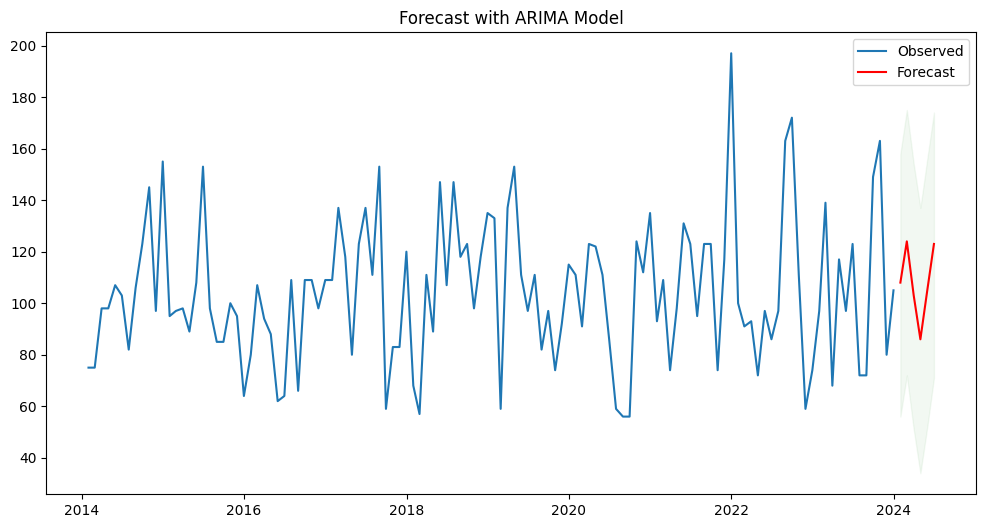

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Observed')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index,conf_int.iloc[:, 0],conf_int.iloc[:, 1],color='green', alpha=0.05)
plt.legend()
plt.title('Forecast with ARIMA Model')
plt.show()

In [ ]:
forecast_summary = pd.concat([forecast_values, conf_int], axis=1)
forecast_summary.columns = ['Forecast', 'Lower Bound', 'Upper Bound']
print(forecast_summary)

            Forecast  Lower Bound  Upper Bound
2024-01-31     108.0         56.0        158.0
2024-02-29     124.0         72.0        175.0
2024-03-31     103.0         51.0        154.0
2024-04-30      86.0         34.0        137.0
2024-05-31     105.0         52.0        156.0
2024-06-30     123.0         71.0        174.0
